# Applying Growth Coupling In Community
Exploring how the commuinty model can compensate for the knocked out reactions. 

In [2]:
import micom as mc
import cobra.io
com = mc.load_pickle("../../data/community.pickle")
GD = cobra.io.read_sbml_model("../../data/GD.xml")
# ijo = cobra.io.read_sbml_model("../../data/iJO1366.xml")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-10
Read LP format model from file C:\Users\domin\AppData\Local\Temp\tmpd7qtx32z.lp
Reading time = 0.14 seconds
: 4042 rows, 11287 columns, 43241 nonzeros


In [3]:
com.medium
# com.reactions.EX_

{'EX_co2_m': 1000.0,
 'EX_cobalt2_m': 1000.0,
 'EX_glc__D_m': 10.0,
 'EX_h_m': 1000.0,
 'EX_h2o_m': 1000.0,
 'EX_k_m': 1000.0,
 'EX_cu2_m': 1000.0,
 'EX_mg2_m': 1000.0,
 'EX_mn2_m': 1000.0,
 'EX_mobd_m': 1000.0,
 'EX_na1_m': 1000.0,
 'EX_nh4_m': 1000.0,
 'EX_ca2_m': 1000.0,
 'EX_cbl1_m': 0.01,
 'EX_ni2_m': 1000.0,
 'EX_o2_m': 1000.0,
 'EX_cl_m': 1000.0,
 'EX_pi_m': 1000.0,
 'EX_xyl__D_m': 10.0,
 'EX_zn2_m': 1000.0,
 'EX_sel_m': 1000.0,
 'EX_slnt_m': 1000.0,
 'EX_so4_m': 1000.0,
 'EX_tungs_m': 1000.0,
 'EX_fe2_m': 1000.0,
 'EX_fe3_m': 1000.0}

In [4]:
# Apply the growth couple strategy to the individual model
strat = ["TALA","EDD","FBA","F6PA","PPM2","AGM4PApp","INDOLEt2pp","AGM3PApp"]

# Not mapped EDD PPM2 AGM4PApp","INDOLEt2pp","AGM3PApp

sols = {}
with GD:
    # Allow presence of Tyrosol
    GD.reactions.EX_Tyrosol_e.bounds = (-10,1000)    
    for i in GD.reactions:
        if i.id in strat:
            print(i.id, i.bounds)
            i.bounds = (0,0)
    sols["GD"] = GD.optimize()
    



FBA (-1000.0, 1000.0)
TALA (-1000.0, 1000.0)
EDD (0.0, 1000.0)
F6PA (-1000.0, 1000.0)
PPM2 (-1000.0, 1000.0)
AGM4PApp (0.0, 1000.0)
INDOLEt2pp (0.0, 1000.0)
AGM3PApp (0.0, 1000.0)


In [5]:
# Identify exchanges carrying flux:
x = sols["GD"]
# Get fluxes of exchanges
x = x.to_frame()

temp = [i.id for i in GD.exchanges]
# df.loc[df["name"].isin(["Xavier", "Joaquin"]), :])
# x.loc[x[x.index].isin(temp),:]


# This is the active excahnges for the GD model 
def get_active_Exchanges(m,sol):
    # Takes a model object and a corresponding solution object and returns a dictionary of the active exchanges in the solution.
    try:
        sol = sol.to_frame()
    except:
        pass
    ans = {}
    for i in [j.id for j in m.exchanges]:
        if i in sol.index and sol.loc[i].fluxes !=0:
            ans[i] = sol.loc[i].fluxes
    return ans


GD_ind_exFluxes = get_active_Exchanges(GD, x)


In [6]:
# Can we identify a list of metabolites that have a direct relationship with those reactions knocked out?
tgt_rxns = [i for i in GD.reactions if i.id in strat]

metabolites_of_interest = set()
for i in tgt_rxns:
    for j in i.metabolites:
        # print(j.id)
        metabolites_of_interest.add(j.id) # change to j if want actual reactions, the id should be fine.

metabolites_of_interest # we can take this list and use it to identify direct cross feeding circumvention of the blocked reactions.




{'2ddg6p_c',
 '2dr1p_c',
 '2dr5p_c',
 '6pgc_c',
 'LalaDgluMdapDala_p',
 'LalaDgluMdap_p',
 'anhgm3p_p',
 'anhgm4p_p',
 'anhgm_p',
 'dha_c',
 'dhap_c',
 'e4p_c',
 'f6p_c',
 'fdp_c',
 'g3p_c',
 'h2o_c',
 'h2o_p',
 'h_c',
 'h_p',
 'indole_c',
 'indole_p',
 's7p_c'}

In [7]:
"""
Some observations, the flux output of salidroside is equal to the flux input of tyrosol, but is not at the bound imposed by the medium availiblity, suggesting that there
is another limiting factor - likely to be UDPGlucose 
"""
x = sols["GD"]
# x.fluxes


## Community

In [8]:
# Baseline community model
sol = com.cooperative_tradeoff(fraction=0.95,fluxes=True, pfba=True) 

In [9]:
# Apply the coupling reaction constraints to the community
strat = ["TALA","EDD","FBA","F6PA","PPM2","AGM4PApp","INDOLEt2pp","AGM3PApp"] # Original 
strat = [i+"__GD_uc" for i in strat]

# com.reactions.EX_Tyrosol_m.bounds
with com:
    for i in com.reactions:
        if i.id in strat:
            print(i.id, i.bounds)
            i.bounds = (0,0)
    
    # sols.append(com.cooperative_tradeoff(fraction=0.95,pfba=True, fluxes=True))
    sols["com_GC"] = com.cooperative_tradeoff(fraction=0.95,pfba=True, fluxes=True)
        

FBA__GD_uc (-1000.0, 1000.0)
TALA__GD_uc (-1000.0, 1000.0)
EDD__GD_uc (0.0, 1000.0)
F6PA__GD_uc (-1000.0, 1000.0)
PPM2__GD_uc (-1000.0, 1000.0)
AGM4PApp__GD_uc (0.0, 1000.0)
INDOLEt2pp__GD_uc (0.0, 1000.0)
AGM3PApp__GD_uc (0.0, 1000.0)


In [10]:
# Show that salidroside is not being produced in communtiy.
x = sols["com_GC"]
x.fluxes.T.loc["SALIDROSIDE_BIOSYNTHESIS"]

compartment
AG_uc     NaN
GD_uc     0.0
medium    NaN
Name: SALIDROSIDE_BIOSYNTHESIS, dtype: float64

In [11]:
# Heuristic search for finding exchange reactions in the community model that will directly circumvent the imposed growth coupling strategy.
from utils import getInternalExchangeFluxes
# Find the internal exchanges that carry flux.
comintex = getInternalExchangeFluxes(com, x)
comintex.GD_uc
# For each reaction therein identify those containing metabolites from the metabolites of interest. 
candidates = []
for intex in [i+"__GD_uc" for i in comintex.index]:
    rxn = [i for i in com.reactions if i.id == intex][0]
    # print(rxn.id, rxn.metabolites)
    # print([i.id for i in rxn.metabolites]) # Remove the compartment suffix to allow matching
    for k in metabolites_of_interest:
        if k[:-1] in [i.id[:-1] for i in rxn.metabolites]:
            candidates.append(rxn.id)

print(set(candidates))

# So dha or dehydroxyacetate is a clear culprit for circumventing the blocking of F6PA which catalyses the conversion of dha into fructose 6 phosphate under the F6PA reaction

{'EX_h2o_e__GD_uc', 'EX_dha_e__GD_uc', 'EX_h_e__GD_uc'}


In [12]:
# Next evaluate 
#  a) those reactions that are present in the community solution and not the single culture
#  and b) the change in rections that are present across both community and individually.

# comintex.GD_uc.index

print(len(comintex.AG_uc.index))
print(len(GD_ind_exFluxes.keys()))

print("Community Internal Exchange Reactions that are not in individual solution ")
for i in comintex.AG_uc.index:
    if i not in GD_ind_exFluxes:
        print(i)




42
23
Community Internal Exchange Reactions that are not in individual solution 
EX_akg_e
EX_dha_e
EX_ser__L_e
EX_glu__L_e
EX_asp__L_e
EX_gly_e
EX_leu__L_e
EX_val__L_e
EX_arg__L_e
EX_ile__L_e
EX_thr__L_e
EX_hxan_e
EX_asn__L_e
EX_pro__L_e
EX_ade_e
EX_his__L_e
EX_thymd_e
EX_xyl__D_e
EX_trp__L_e
EX_phe__L_e
EX_glcn_e


In [13]:
comintex.head()

compartment,AG_uc,GD_uc
reaction,,
EX_o2_e,-35.405848,-41.398678
EX_glc__D_e,0.000000,-19.989678
EX_akg_e,8.183884,-8.183884
EX_dha_e,5.095079,-5.095079
EX_nh4_e,-31.321930,-4.476836


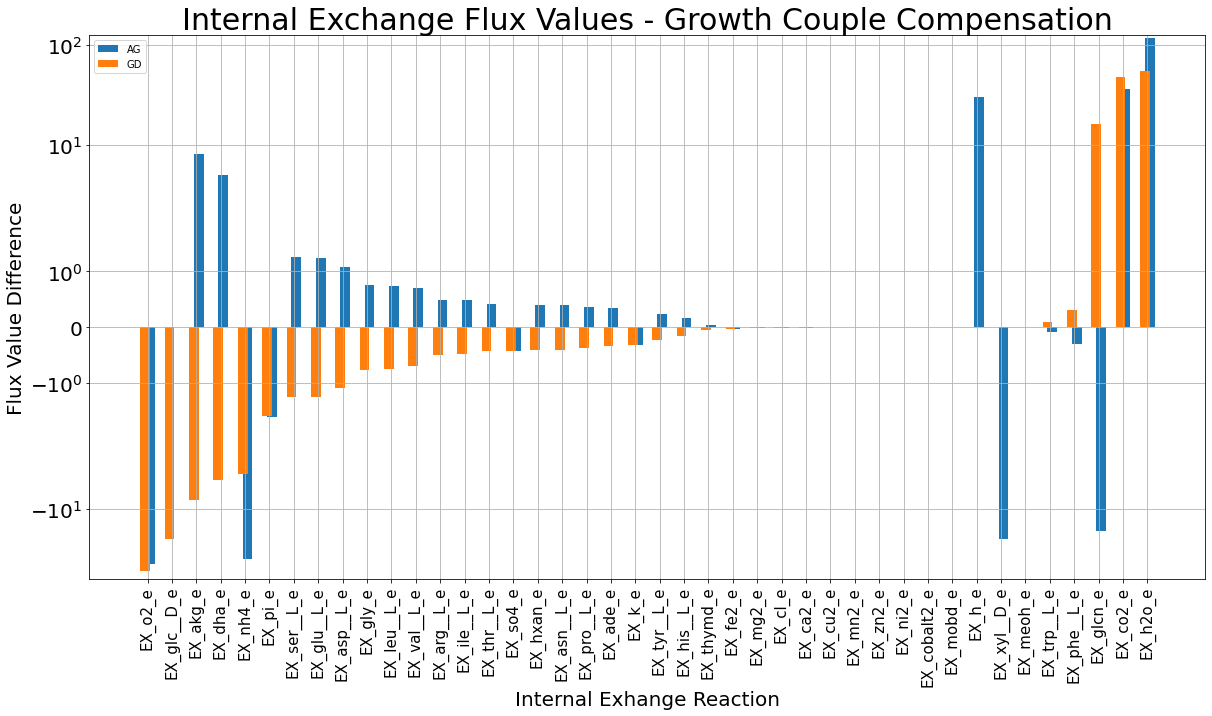

In [16]:
from utils import *
from utilPlots import *

plotIntExchFlux(com, comintex,_title = "Internal Exchange Flux Values - Growth Couple Compensation", save_output=True)
